In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# version and gpu
print(torch.__version__)
print(torch.cuda.is_available())


2.2.1+cu121
True


In [36]:
import numpy as np

# Load data
manta_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)

# resize manta and xiris to 224x224
# resize manta with opencv
import cv2
# Define the target size
target_size = (224, 224)

# Create empty lists to store resized images
manta_resized = []
xiris_resized = []

# Loop through each image in manta and xiris
for img_manta, img_xiris in zip(manta, xiris):
    # Resize images using cv2.resize function
    resized_manta = cv2.resize(img_manta, target_size, interpolation=cv2.INTER_LINEAR)
    resized_xiris = cv2.resize(img_xiris, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Append resized images to the respective lists
    manta_resized.append(resized_manta)
    xiris_resized.append(resized_xiris)

# del manta and xiris
del manta
del xiris


# dimensions of MP are the index 1 and 2 of column in feat
dim_lh = feats[:, 1:3]

# get max of each column
max_lh = np.max(dim_lh, axis=0)
print(max_lh)

# normalize
dim_lh = dim_lh / max_lh
print(dim_lh)

# expand the dimension of x to 4D
manta = np.expand_dims(manta_resized, axis=3)
xiris = np.expand_dims(xiris_resized, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm as notebook_tqdm

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

# Extend third channel by duplicating it
X_train = np.concatenate((X_train, X_train[:, :, :, 0:1]), axis=3)
X_test = np.concatenate((X_test, X_test[:, :, :, 0:1]), axis=3)

# print shapes
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Create dataset and dataloader
class MantaIrisDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {'x': self.X[idx], 'y': self.y[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    def __call__(self, sample):
        x, y = sample['x'], sample['y']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        x = x.transpose((2, 0, 1))
        return {'x': torch.from_numpy(x).float(),
                'y': torch.from_numpy(y).float()}

transformed_dataset_train = MantaIrisDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]))
transformed_dataset_test = MantaIrisDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]))

dataloader_train = DataLoader(transformed_dataset_train, batch_size=32, shuffle=True, num_workers=6)
dataloader_test = DataLoader(transformed_dataset_test, batch_size=32, shuffle=False, num_workers=6)

X_train shape:  (7669, 224, 224, 3)
X_test shape:  (1918, 224, 224, 3)


Max val: 1.0
Min: 0.001640631235204637


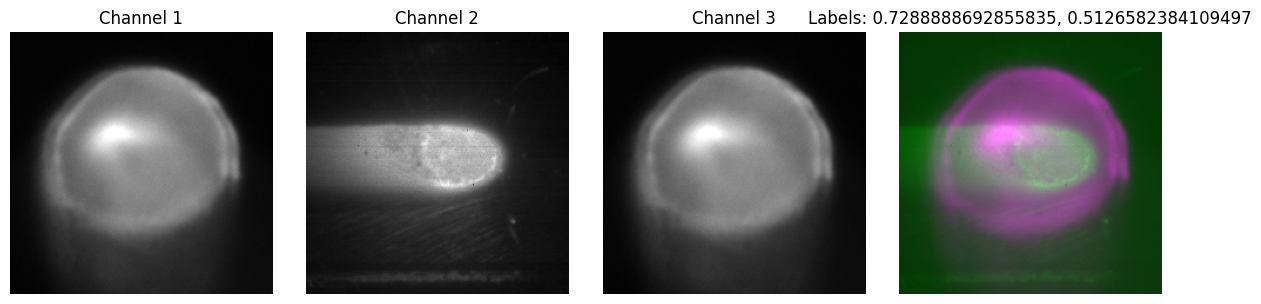

In [31]:
import matplotlib.pyplot as plt

# Function to visualize images from DataLoader
def visualize_single_image(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch['x'], batch['y']
    
    img = images[0]  # Fetch the first image
    
    # Print max and min values for each channel in the current image
    print("Max val:", torch.max(img).item())
    print("Min:",  torch.min(img).item())

    
    # Plot the image
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for j in range(3):  # Plot each channel separately
        axes[j].imshow(img[j], cmap='gray')
        axes[j].set_title(f"Channel {j+1}")
        axes[j].axis('off')
    # Plot the combined image
    combined_img = img.permute(1, 2, 0)  # Convert from C x H x W to H x W x C
    axes[3].imshow(combined_img)
    label_text = f"Labels: {', '.join([str(label.item()) for label in labels[0]])}"
    axes[3].set_title(label_text)
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()
    

# Visualize one image from training DataLoader
visualize_single_image(dataloader_train)

# Function to visualize images from DataLoader
def visualize_multiple_images(dataloader, num_images=2):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch['x'], batch['y']
    
    # Plot the images
    fig, axes = plt.subplots(num_images, 4, figsize=(12, 6))
    for i in range(num_images):
        img = images[i]  # Fetch the image
        for j in range(3):  # Plot each channel separately
            axes[i, j].imshow(img[j], cmap='gray')
            axes[i, j].set_title(f"Channel {j+1}")
            axes[i, j].axis('off')
        # Plot the combined image
        combined_img = img.permute(1, 2, 0)  # Convert from C x H x W to H x W x C
        axes[i, 3].imshow(combined_img)
        label_text = f"Labels: {', '.join([str(label.item()) for label in labels[i]])}"
        axes[i, 3].set_title(label_text)
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images from training DataLoader
#visualize_multiple_images(dataloader_train, num_images=2)
# Visualize images from testing DataLoader
# visualize_multiple_images(dataloader_test, num_images=2)



In [37]:
# Define the model

class SimpleCNN_reg(nn.Module):
    def __init__(self):
        super(SimpleCNN_reg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 4 channels -> 3 channels + batch size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*28*28, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Create the model
model = SimpleCNN_reg()
print(model)   

SimpleCNN_reg(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [41]:
import torch
import torch.nn as nn
from tqdm import tqdm  # Import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming 'model' is already defined and needs to be moved to the appropriate device
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 10
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    # Wrap the training data loader with tqdm
    for i, batch in enumerate(tqdm(dataloader_train, desc=f'Epoch {epoch+1}/{n_epochs}')):
        images, labels = batch['x'].to(device), batch['y'].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)
    
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        # Wrap the testing data loader with tqdm
        for batch in tqdm(dataloader_test, desc='Validation'):
            images, labels = batch['x'].to(device), batch['y'].to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(dataloader_test)
    test_losses.append(test_loss)
    
    # Print training and validation information
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}")

# Optionally save the trained model
#torch.save(model.state_dict(), 'trained_model.pth')


Validation: 100%|██████████| 60/60 [00:02<00:00, 28.06it/s]


Epoch 1/10, Training Loss: 0.0039, Validation Loss: 0.0003


Validation: 100%|██████████| 60/60 [00:02<00:00, 29.60it/s]


Epoch 2/10, Training Loss: 0.0005, Validation Loss: 0.0002


Validation: 100%|██████████| 60/60 [00:02<00:00, 28.88it/s]


Epoch 3/10, Training Loss: 0.0004, Validation Loss: 0.0002


Validation: 100%|██████████| 60/60 [00:02<00:00, 27.25it/s]


Epoch 4/10, Training Loss: 0.0004, Validation Loss: 0.0003


Validation: 100%|██████████| 60/60 [00:02<00:00, 26.75it/s]


Epoch 5/10, Training Loss: 0.0004, Validation Loss: 0.0004


Validation: 100%|██████████| 60/60 [00:02<00:00, 25.02it/s]


Epoch 6/10, Training Loss: 0.0003, Validation Loss: 0.0004


Validation: 100%|██████████| 60/60 [00:02<00:00, 28.94it/s]


Epoch 7/10, Training Loss: 0.0003, Validation Loss: 0.0005


Validation: 100%|██████████| 60/60 [00:01<00:00, 30.37it/s]


Epoch 8/10, Training Loss: 0.0003, Validation Loss: 0.0003


Validation: 100%|██████████| 60/60 [00:02<00:00, 27.09it/s]


Epoch 9/10, Training Loss: 0.0003, Validation Loss: 0.0003


Validation: 100%|██████████| 60/60 [00:02<00:00, 26.51it/s]

Epoch 10/10, Training Loss: 0.0003, Validation Loss: 0.0002


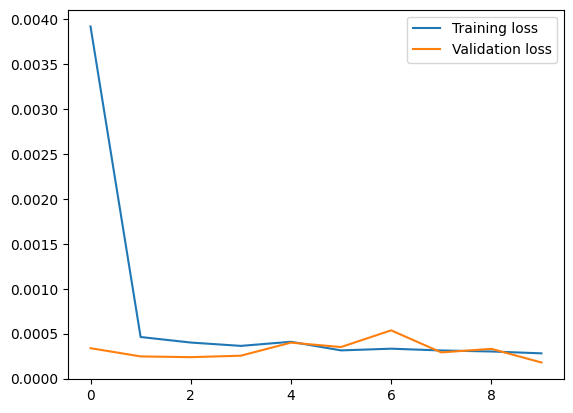

In [44]:
# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()


Validation: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


Mean Squared Error: 0.0002


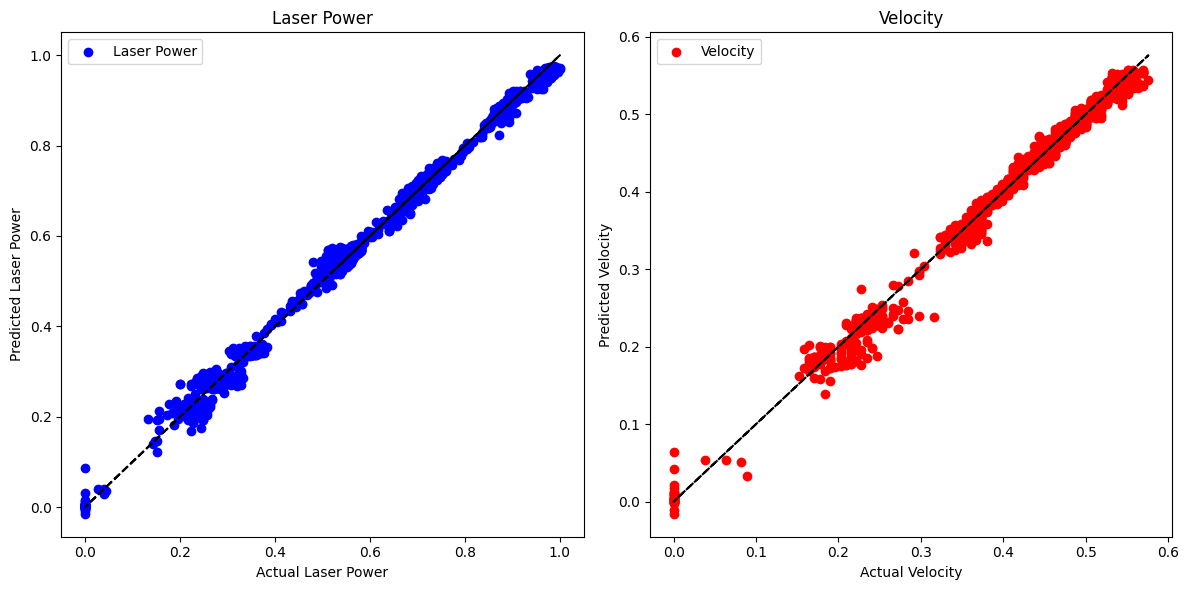

In [47]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predicted and actual labels
predicted_labels = []
actual_labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(dataloader_test, desc='Validation'):
        images, labels = batch['x'].to(device), batch['y'].to(device)  # Move data to GPU
        outputs = model(images)
        predicted_labels.append(outputs.cpu())  # Move predictions to CPU
        actual_labels.append(labels.cpu())  # Move actual labels to CPU

# Concatenate the lists to obtain the predicted and actual labels
predicted_labels = torch.cat(predicted_labels)
actual_labels = torch.cat(actual_labels)

# Calculate the mean squared error
mse = nn.MSELoss()
loss = mse(predicted_labels, actual_labels)
print(f"Mean Squared Error: {loss.item():.4f}")

# Plot the predicted and actual labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(actual_labels[:, 0], predicted_labels[:, 0], label='Laser Power', color='blue')
plt.plot(actual_labels[:, 0], actual_labels[:, 0], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Laser Power')
plt.ylabel('Predicted Laser Power')
plt.title('Laser Power')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual_labels[:, 1], predicted_labels[:, 1], label='Velocity', color='red')
plt.plot(actual_labels[:, 1], actual_labels[:, 1], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Velocity')
plt.ylabel('Predicted Velocity')
plt.title('Velocity')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the activations and corresponding labels
activations = []
labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(dataloader_test, desc='Validation'):
        images, targets = batch['x'].to(device), batch['y']
        # Forward pass until the fc1 layer
        outputs = model(images)
        output_fc1 = model.fc1.weight.data.cpu().numpy()
        # Append to the list of activations
        activations.extend(output_fc1)
        # Append to the list of labels
        labels.extend(targets)

# Convert lists to NumPy arrays
activations = np.array(activations)
labels = np.array(labels)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(activations)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(activations)

# Plot PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.title('PCA')

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.title('t-SNE')

plt.show()


Validation: 100%|██████████| 60/60 [00:10<00:00,  5.96it/s]
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild th